In [1]:
# model class 

import torch 
from torch import nn 
from tqdm.auto import tqdm 

import json
from importlib import reload

import torch
import numpy as np
import pandas as pd 
from tqdm.auto import tqdm
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix, roc_auc_score


class BiLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_size, nclasses, class_weigths=None, device='cpu') -> None:
        super().__init__()

        # self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim).to(device)
        self.lstm_model = nn.LSTM(embedding_dim, hidden_size//2, bidirectional=True).to(device)
        self.ffwd_lay = nn.Linear(hidden_size, nclasses).to(device)
        self.softmax = nn.Softmax(dim=1).to(device)

        self.optim = torch.optim.Adam(self.parameters(), lr=1e-2)
        self.criterion = nn.CrossEntropyLoss(weight=class_weigths)
        
        self.loss_history = []


    def forward(self, batch):
        # out = self.embedding(batch) # L x vocab_size -> L x embedding_dim
        out = self.lstm_model(batch)[0] # L x hidden_size
        out = self.ffwd_lay(out) # L x nclasses
        return self.softmax(out)


    def fit(self, train_X, train_Y, valid_X, valid_Y, nepochs, lr, device):
        self.train()
        self.to(device)

        for g in self.optim.param_groups:
            g['lr'] = lr    
        
        for ep in tqdm(range(nepochs)):
            eploss = 0

            for batch_X, batch_Y in zip(train_X, train_Y):
                predict = self.forward(batch_X.to(device))
                
                self.optim.zero_grad()
                loss = self.criterion(predict, batch_Y.to(device))
                loss.backward()
                self.optim.step()

                eploss += loss.item()
                self.loss_history.append(loss.item())
            
            printbool = ep % (nepochs//10) == 0 if nepochs > 10 else True
            if printbool:
                with torch.no_grad():
                    train_predict = []
                    for batch_X in train_X:
                        predict = torch.argmax(self.forward(batch_X.to(device)), dim=1)
                        train_predict.append(predict.cpu())
                    
                    train_predict = torch.cat(train_predict)
                    train_real = torch.cat(train_Y)
    
                    test_predict = []
                    for batch_X in valid_X:
                        predict = torch.argmax(self.forward(batch_X.to(device)), dim=1)
                        test_predict.append(predict.cpu())
                    
                    test_predict = torch.cat(test_predict)
                    test_real = torch.cat(valid_Y)

                    # train_predict, train_real = train_predict[train_predict != 0], train_real[train_predict != 0]
                    # test_predict, test_real = test_predict[test_predict != 0], test_real[test_predict != 0]
                    TP = ((train_predict == train_real) & (train_predict != 0)).sum()
                    FP = ((train_predict != train_real) & (train_predict != 0)).sum()
                    acc_metric_train = TP / (TP + FP)

                    TP = ((test_predict == test_real) & (test_predict != 0)).sum()
                    FP = ((test_predict != test_real) & (test_predict != 0)).sum()
                    acc_metric_valid = TP / (TP + FP)
                    
                    print(f'Iter: {ep}, Loss: {eploss/len(train_X):.3f} Train precision {acc_metric_train:.3f}:, Valid precision: {acc_metric_valid:.3f}')
                    # print(f'Iter: {ep}, Loss: {eploss/len(train_X):.3f} Train BA: {balanced_accuracy_score(train_real, train_predict):.3f}, Train F1: {f1_score(train_real, train_predict, average="micro"):.3f}, Valid BA: {balanced_accuracy_score(test_real, test_predict):.3f}, Valid F1: {f1_score(test_real, test_predict, average="micro"):.3f}')
                        
            # printbool = ep % (nepochs//10) == 0 if nepochs > 10 else True
            # if printbool:
            #     print(f'Train loss: {eploss/len(train_X):.3f}')

In [2]:
def data_label_split(data, label, train_size=0.8):
    randidx = np.arange(len(data))
    data_train, data_test = train_test_split(data, randidx, train_size)
    label_train, label_test = train_test_split(label, randidx, train_size)

    return data_train, data_test, label_train, label_test

def train_test_split(data, randidx, train_size):
    N = len(data)
    return [data[i] for i in randidx[:int(train_size*N)]], [data[i] for i in randidx[int(train_size*N):]]

def shuffle_data_label_lists(data, label):
    randidx = np.arange(len(data))
    np.random.shuffle(randidx)
    return [data[i] for i in randidx], [label[i] for i in randidx]

def batch_split(X, Y, seq_len, batch_size=1000):
    x_batched = []
    y_batched = []
    seq_len_batched = []

    n = len(X)
    pointer = 0
    while pointer + batch_size < n:
        x_batched.append(X[pointer:pointer+batch_size])
        y_batched.append(Y[pointer:pointer+batch_size])
        seq_len_batched.append(seq_len[pointer:pointer+batch_size])
        pointer += batch_size 
    
    x_batched.append(X[pointer:])
    y_batched.append(Y[pointer:])
    seq_len_batched.append(seq_len[pointer:])

    return x_batched, y_batched, seq_len_batched


label2num = {
    'B-NAME_STUDENT': 0, 
    'I-NAME_STUDENT': 0, 
    'B-STREET_ADDRESS': 1, 
    'I-STREET_ADDRESS': 1, 
    'B-USERNAME': 2,
    'I-USERNAME': 2, 
    'B-ID_NUM': 3, 
    'I-ID_NUM': 3, 
    
    'O': 0,
    'B-URL_PERSONAL': 0, 
    'I-URL_PERSONAL': 0, 
    'B-EMAIL': 0, 
    'I-EMAIL': 0,
    'B-PHONE_NUM': 0, 
    'I-PHONE_NUM': 0, 
}

num2label = {
    0: 'O',
    # 1: 'NAME_STUDENT', 
    1: 'STREET_ADDRESS', 
    2: 'USERNAME',
    3: 'ID_NUM',  
}

In [3]:
# load fastext
token2emb = {}
with open('wiki-news-300d-1M.vec', 'r', encoding='utf-8') as f:
    next(f)
    for it in tqdm(f):
        row = it.split(' ')
        token2emb[row[0]] = list(map(float, row[1:]))


# encoding tokens and labels
with open('data/mixtral-8x7b-v1.json', 'r', encoding='utf-8') as f:
    data_1 = json.load(f)
with open('data/train.json', 'r', encoding='utf-8') as f:
    data_2 = json.load(f)
data = data_1 + data_2
    
randidx = np.arange(len(data))
np.random.shuffle(randidx)
data = [data[i] for i in randidx]

train_data, valid_data = data[:7000], data[7000:]

train_tokens = []
train_labels = []
for doc in tqdm(train_data):
    train_tokens.append(torch.FloatTensor([token2emb[it] if it in token2emb else [0]*300 for it in doc['tokens']]))
    train_labels.append(torch.LongTensor([label2num[it] if it in label2num else 0 for it in doc['labels']]))

test_tokens = []
test_labels = []
for doc in tqdm(valid_data):
    test_tokens.append(torch.FloatTensor([token2emb[it] if it in token2emb else [0]*300 for it in doc['tokens']]))
    test_labels.append(torch.LongTensor([label2num[it] if it in label2num else 0 for it in doc['labels']]))

0it [00:00, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/2162 [00:00<?, ?it/s]

In [4]:
import gc
token2emb = []
gc.collect()

40

In [5]:
class_weigths = torch.zeros(max(label2num.values())+1)
for i in range(len(class_weigths)):
    class_weigths[i] = sum([(it == i).sum().item() for it in train_labels])
class_weigths = 1 / class_weigths 
class_weigths /= class_weigths.sum()

# class_weigths /= class_weigths.sum()
# class_weigths = 1 - class_weigths
# class_weigths /= class_weigths.sum()

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
# fit lstm
model = BiLSTM(
    embedding_dim=300,
    hidden_size=128,
    nclasses=len(class_weigths),
    device=device,
    class_weigths=class_weigths
)

In [10]:
model.fit(
    train_tokens,
    train_labels,
    valid_X=test_tokens,
    valid_Y=test_labels,
    nepochs=50,
    lr=5e-3,
    device=device
)

  0%|          | 0/50 [00:00<?, ?it/s]

Iter: 0, Loss: 0.765 Train precision 0.531:, Valid precision: 0.548
Iter: 5, Loss: 0.747 Train precision 0.712:, Valid precision: 0.724
Iter: 10, Loss: 0.747 Train precision 0.704:, Valid precision: 0.708


In [10]:
model.fit(
    train_tokens,
    train_labels,
    valid_X=test_tokens,
    valid_Y=test_labels,
    nepochs=50,
    lr=1e-4,
    device=device
)

  0%|          | 0/50 [00:00<?, ?it/s]

Iter: 0, Loss: 0.906 Train precision 0.876:, Valid precision: 0.867
Iter: 5, Loss: 0.906 Train precision 0.879:, Valid precision: 0.874
Iter: 10, Loss: 0.906 Train precision 0.880:, Valid precision: 0.876
Iter: 15, Loss: 0.906 Train precision 0.882:, Valid precision: 0.878


KeyboardInterrupt: 

In [11]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': model.optim.state_dict(),
    }, 'saved_models/bi_lstm3.pt')

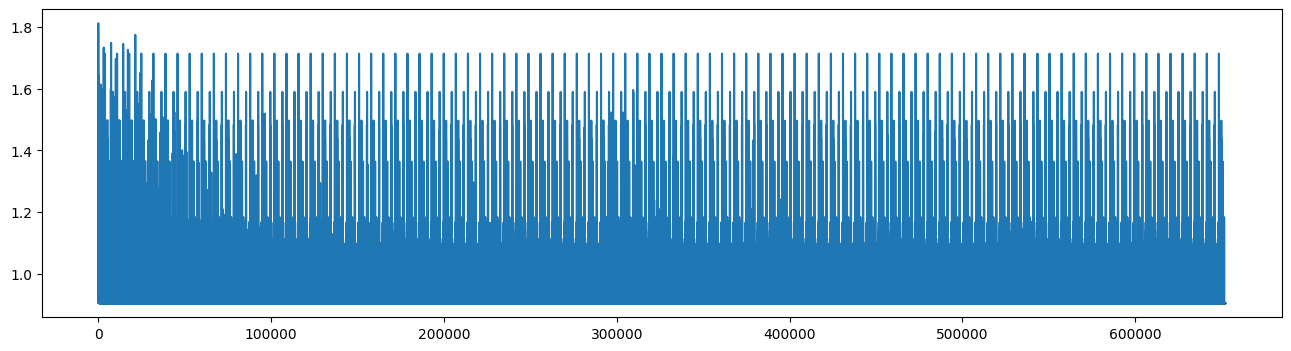

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
plt.plot(model.loss_history)

In [13]:
with torch.no_grad():
    train_predict = []
    train_proba = []
    for batch_X in train_tokens:
        predict_proba = model(batch_X.to(device))[:, 1]
        train_predict.append((predict_proba > 0.5).cpu())
        train_proba.append(predict_proba.cpu())
    
    train_predict = torch.cat(train_predict)
    train_proba = torch.cat(train_proba)
    train_real = torch.cat(train_labels)

    print(f'BA: {balanced_accuracy_score(train_real, train_predict):.3f}')
    print(f'F1: {f1_score(train_real, train_predict, average="micro"):.3f}')
    print(f'ROC AUC: {roc_auc_score(train_real, train_proba):.3f}')

BA: 1.000
F1: 1.000
ROC AUC: 1.000


In [14]:
with torch.no_grad():
    test_predict = []
    test_proba = []
    for batch_X in test_tokens:
        predict_proba = model(batch_X.to(device))[:, 1]
        test_predict.append((predict_proba > 0.5).cpu())
        test_proba.append(predict_proba.cpu())
    
    test_predict = torch.cat(test_predict)
    test_proba = torch.cat(test_proba)
    test_real = torch.cat(test_labels)

    print(f'BA: {balanced_accuracy_score(test_real, test_predict):.3f}')
    print(f'F1: {f1_score(test_real, test_predict, average="micro"):.3f}')
    print(f'ROC AUC: {roc_auc_score(test_real, test_proba):.3f}')

BA: 0.898
F1: 1.000
ROC AUC: 0.968


In [15]:
columns = [
    'O',
    'ID_NUM',
    'NAME_STUDENT',
    'USERNAME',
    'STREET_ADDRESS',
]

pd.DataFrame(confusion_matrix(test_real, test_predict), columns=columns)

,O,NAME_STUDENT
0,1307030,67
1,129,502


In [34]:
token2emb = []
train_tokens = []
train_labels = []
test_tokens = []
test_labels = []

gc.collect()

1192

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = BiLSTM(
    embedding_dim=300,
    hidden_size=128,
    nclasses=5,
    device=device,
    class_weigths=torch.FloatTensor([1]*5)
)
checkpoint = torch.load('saved_models/bi_lstm.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.optim.load_state_dict(checkpoint['optimizer_state_dict'])
model.eval()
model.to(device)
print()

In [3]:
token2emb = {}
with open('wiki-news-300d-1M.vec', 'r', encoding='utf-8') as f:
    next(f)
    for it in tqdm(f):
        row = it.split(' ')
        token2emb[row[0]] = list(map(float, row[1:]))


0it [00:00, ?it/s]

In [13]:
def get_predict_table(data):
    def check_name(x):
        flag = False
        flag = x[0].isupper()
        for it in x[1:]:
            flag *= it.islower()
        return flag


    predict_table = [[], [], [], [], []] # document, token_idx, token, predict, real
    for doc in tqdm(data):
        with torch.no_grad():
            doc_tokens = torch.FloatTensor([token2emb[it] if it in token2emb else [0]*300 for it in doc['tokens']])
            predict = torch.argmax(model.forward(doc_tokens.to(device)), dim=1).cpu()
            predict = [num2label[it.item()] for it in predict]
            predict_table[0] += [doc['document']]*len(predict)
            predict_table[1] += list(range(len(predict)))
            predict_table[2] += doc['tokens']
            predict_table[3] += predict
            predict_table[4] += doc['labels'] 
        
    predict_table = [[predict_table[0][i], predict_table[1][i], predict_table[2][i], predict_table[3][i], predict_table[4][i]] for i in range(len(predict_table[0]))]
    predict_table = pd.DataFrame(predict_table, columns=['document', 'token_i', 'token', 'predict', 'label'])
    predict_table = predict_table.loc[((predict_table.predict != 'O') | (predict_table.label != 'O')) & ((predict_table.token != "\n") | (predict_table.token != "\n\n") | (predict_table.token != "\t"))].reset_index(drop=True)
    predict_table['prefix'] = 'B-'

    predict_table['upper_start'] = predict_table.token.apply(check_name)
    predict_table = predict_table.loc[((predict_table.upper_start == 1) & (predict_table.predict == 'NAME_STUDENT')) | (predict_table.predict != 'NAME_STUDENT')].reset_index(drop=True)
    predict_table = predict_table.sort_values('document').reset_index(drop=True)

    return predict_table

In [14]:
import gc
with open('data/train.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
predict_table = get_predict_table(data)
gc.collect()

  0%|          | 0/6807 [00:00<?, ?it/s]

0

In [21]:
for i in range(1, predict_table.shape[0]):
    if (predict_table.at[i-1, 'predict'] == predict_table.at[i, 'predict']) & (predict_table.at[i-1, 'document'] == predict_table.at[i, 'document']) & (predict_table.at[i, 'token_i'] - predict_table.at[i-1, 'token_i'] == 1):
        predict_table.at[i, 'prefix'] = 'I-'
predict_table['predict'] = predict_table['prefix'] + predict_table['predict']

In [25]:
print(f'F1 score: {f1_score(predict_table.label, predict_table.predict, average="micro")}')

F1 score: 0.7233229058046575


In [33]:
predict_table.loc[predict_table.predict != predict_table.label].groupby('predict', as_index=False).label.count()

,predict,label
0,B-ID_NUM,2
1,B-NAME_STUDENT,469
2,B-O,263
3,B-STREET_ADDRESS,22
4,B-USERNAME,3
5,I-NAME_STUDENT,25
6,I-O,11
7,I-STREET_ADDRESS,1
